## Protest Data Cleaning

In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import os
import sys
import urllib, json, requests
import seaborn as sns

In [2]:
protest_data = pd.read_csv("../raw_data/protest_AECLD.csv")

In [3]:
protest_data.head()

,ISO,EVENT_ID_CNTY,EVENT_ID_NO_CNTY,EVENT_DATE,YEAR,TIME_PRECISION,EVENT_TYPE,SUB_EVENT_TYPE,ACTOR1,ASSOC_ACTOR_1,...,ADMIN2,ADMIN3,LOCATION,LATITUDE,LONGITUDE,GEO_PRECISION,SOURCE,SOURCE_SCALE,NOTES,FATALITIES
0,840,USA4524,4524,24-May-2020,2020,1,Protests,Peaceful protest,Protesters (United States),NaN,...,Baltimore City,NaN,Baltimore,39.290,-76.612,1,Fox45 (Baltimore),Subnational,"On 24 May 2020, a caravan of people staged a m...",0
1,840,USA4525,4525,24-May-2020,2020,1,Protests,Peaceful protest,Protesters (United States),NaN,...,Williamson,NaN,Marion,37.731,-88.933,1,Southern Illinoisan,Subnational,"On 24 May 2020, nearly 50 people held a ""Patri...",0
2,840,USA4526,4526,24-May-2020,2020,1,Protests,Peaceful protest,Protesters (United States),NaN,...,Mahoning,NaN,Youngstown,41.100,-80.650,1,WKBN,Subnational,"On 24 May 2020, an unreported number of people...",0
3,840,USA4527,4527,24-May-2020,2020,1,Protests,Peaceful protest,Protesters (United States),Teachers (United States); Latinx Group (United...,...,Middlesex,NaN,New Brunswick,40.486,-74.452,1,My Central Jersey,Subnational,"On 24 May 2020, more than a dozen vehicles, or...",0
4,840,USA4528,4528,24-May-2020,2020,1,Protests,Peaceful protest,Protesters (United States),NaN,...,Essex,NaN,Keene,44.256,-73.792,1,Post-Star,Subnational,"On 24 May 2020, a few people staged a protest ...",0


In [4]:
empty_search = r'no\ report'
empty = protest_data.NOTES.str.findall(empty_search)

count_empty = 0
for i in empty:
    if i:
        count_empty = count_empty + 1

count_empty

6603

In [5]:
sr = r'\[size=(.*)\]'
nums = r'\d+|few\ dozen*|few\ hundred*|few\ thousand*|several\ dozen*|several\ hundred*|several\ thousand*|dozen*|hundred*|thousand*'
sizes = protest_data.NOTES.str.findall(sr)
unique_sizes = [list(x) for x in set(tuple(x) for x in sizes)]
size_temp_df = pd.DataFrame([''.join(x) for x in sizes], columns = ['string'])
size_labs = size_temp_df.string.str.findall(nums)

count_recovered = 0
for i in size_labs:
    if i:
        count_recovered = count_recovered + 1

count_recovered

print(f'{count_recovered} of the {len(protest_data) - count_empty} non-emtpy records were retrieved.')

size_cleaned = [None] * len(protest_data)

dozen = 12
few_dozen = 50
hundred = 100
few_hundred = 500
thousand = 1000
few_thousand = 5000

for ii in range(len(size_labs)):
    
    vals = size_labs[ii]
    
    if any(st == "few dozen" for st in vals) | any(st == "several dozen" for st in vals):
        size_cleaned[ii] = few_dozen
    elif any(st == "few hundred" for st in vals) | any(st == "several hundred" for st in vals):
        size_cleaned[ii] = few_hundred
    elif any(st == "few thousand" for st in vals) | any(st == "several thousand" for st in vals):
        size_cleaned[ii] = few_thousand
    elif any(st == "dozen" for st in vals):
        size_cleaned[ii] = dozen
    elif any(st == "hundred" for st in vals):
        size_cleaned[ii] = hundred
    elif any(st == "thousand" for st in vals):
        size_cleaned[ii] = thousand
    else:
        size_cleaned[ii] = np.mean(np.array(vals, dtype=np.float32).astype(np.float))

print(len(size_cleaned))
protest_data["size"] = size_cleaned


9201 of the 10277 non-emtpy records were retrieved.


/Users/Sapthau/opt/anaconda3/envs/cs109a/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/Sapthau/opt/anaconda3/envs/cs109a/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


16880


In [8]:
protest_data["99 or less"] = (protest_data["size"] <= 99) * 1
protest_data["100 to 499"] = ((protest_data["size"] > 99) &(protest_data["size"] <= 499)) * 1
protest_data["500 to 999"] = ((protest_data["size"] > 499) & (protest_data["size"] <= 999)) * 1
protest_data["1000 to 4999"] = ((protest_data["size"] > 999) & (protest_data["size"] <= 4999)) * 1
protest_data["more than 4999"] = ((protest_data["size"] > 4999)) * 1
protest_data

sizes = ["99 or less", "100 to 499", "500 to 999", "1000 to 4999", "more than 4999"]

In [9]:
protest_data.dtypes

ISO                   int64
EVENT_ID_CNTY        object
EVENT_ID_NO_CNTY      int64
EVENT_DATE           object
YEAR                  int64
TIME_PRECISION        int64
EVENT_TYPE           object
SUB_EVENT_TYPE       object
ACTOR1               object
ASSOC_ACTOR_1        object
INTER1                int64
ACTOR2               object
ASSOC_ACTOR_2        object
INTER2                int64
INTERACTION           int64
REGION               object
COUNTRY              object
ADMIN1               object
ADMIN2               object
ADMIN3              float64
LOCATION             object
LATITUDE            float64
LONGITUDE           float64
GEO_PRECISION         int64
SOURCE               object
SOURCE_SCALE         object
NOTES                object
FATALITIES            int64
size                float64
99 or less            int64
100 to 499            int64
500 to 999            int64
1000 to 4999          int64
more than 4999        int64
dtype: object

In [10]:
convert={'fips': lambda x: str(x), 'EVENT_DATE': lambda x: pd.to_datetime(x)}
protest_fips = pd.read_csv("../processed_data/protests_fips.csv", converters = convert)
protest_fips

,EVENT_DATE,EVENT_ID_CNTY,fips
0,2020-05-24,USA4524,24510
1,2020-05-24,USA4525,17199
2,2020-05-24,USA4526,39099
3,2020-05-24,USA4527,34023
4,2020-05-24,USA4528,36031
...,...,...,...
16875,2020-11-07,USA16945,28049
16876,2020-11-07,USA16988,13051
16877,2020-11-07,USA16999,18167
16878,2020-11-07,USA17010,10003


In [11]:
protest_data.EVENT_DATE = pd.to_datetime(protest_data.EVENT_DATE)
protest_data = protest_data.replace('', np.nan)
protest_fips["EVENT_DATE"] = pd.to_datetime(protest_fips.EVENT_DATE)
protest_data_full = protest_data.join(protest_fips.fips,  how = "left")
var_list = ["fips", "EVENT_DATE","99 or less", "100 to 499", "500 to 999", "1000 to 4999", "more than 4999"]
protest_data_full
protest_data_clean = protest_data_full[var_list]
protest_data_clean["unknown"] = (protest_data_clean[["99 or less", "100 to 499","500 to 999", "1000 to 4999", "more than 4999"]].sum(axis = 1) == 0).astype(int)
protest_data_clean.dtypes


/Users/Sapthau/opt/anaconda3/envs/cs109a/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


fips                      object
EVENT_DATE        datetime64[ns]
99 or less                 int64
100 to 499                 int64
500 to 999                 int64
1000 to 4999               int64
more than 4999             int64
unknown                    int64
dtype: object

In [12]:
protest_data_clean.to_csv("../processed_data/protests.csv", index = False)

## FIPS Codes

In [10]:
def progressbar(n_step, n_total):
    """Prints self-updating progress bar to stdout to track for-loop progress
    
    There are entire 3rd-party libraries dedicated to custom progress-bars.
    A simple function like this is often more than enough to get the job done.
    
    :param n_total: total number of expected for-loop iterations
    :type n_total: int
    :param n_step: current iteration number, starting at 0
    :type n_step: int

    .. example::
    
        for i in range(n_iterations):
            progressbar(i, n_iterations)
            
    .. source:
    
        This function is a simplified version of code found here:
        https://stackoverflow.com/questions/3160699/python-progress-bar/15860757#15860757
    """
    n_step = n_step + 1
    barlen = 50
    progress = n_step / n_total
    block = int(round(barlen * progress))
    status = ""
    if n_step == n_total:
        status = "Done...\r\n\n"
    text = "\r [{0}] {1}/{2} {3}".format(
        "=" * block + "-" * (barlen - block),
        n_step,
        n_total,
        status,
    )
    sys.stdout.write(text)
    sys.stdout.flush()

In [11]:
fips_codes = []

for i in range(len(protest_data)):
    
    temp_url = "https://geo.fcc.gov/api/census/area?lat=" +str(protest_data.LATITUDE[i]) +"&lon=" + str(protest_data.LONGITUDE[i])+ "&format=json"
    
    with urllib.request.urlopen(temp_url) as url:
        data = json.loads(url.read().decode())
    
    if not data["results"]:
        fips_codes.append("")
    else:
        fips_codes.append(data["results"][0]["county_fips"])
        
    progressbar(i, len(protest_data))

print(fips_codes)

 [==================================================] 16880/16880 Done...

['24510', '17199', '39099', '34023', '36031', '36081', '36031', '27053', '17031', '37119', '21073', '37133', '42039', '34029', '25025', '33015', '04013', '17163', '27053', '12073', '26161', '18089', '26161', '06059', '48201', '06037', '42101', '51760', '18141', '27123', '27137', '06107', '17031', '24027', '26161', '27053', '41051', '27163', '26161', '37119', '12021', '45003', '27137', '24015', '06037', '47157', '36061', '37183', '06073', '06067', '42027', '53007', '29095', '40143', '36119', '08031', '27163', '26161', '26161', '27053', '25017', '08069', '08031', '35001', '39049', '27123', '26161', '41051', '19113', '01089', '41039', '26161', '06071', '27003', '27123', '27123', '06037', '27053', '29510', '53061', '27037', '47157', '27037', '23011', '48245', '01073', '27003', '25025', '12081', '27035', '17031', '45079', '27137', '48141', '41039', '41067', '42001', '06001', '26065', '32003', '32003', '06037', '21111

In [28]:
protest_data["fips_county"] = fips_codes
protest_data["fips_county"] = protest_data.fips_county.astype(str)

Old code to export FIPS codes for later use

In [32]:
fips_output = protest_data[["EVENT_DATE", "EVENT_ID_CNTY"]]
fips_output["fips"] = fips_codes
fips_output.EVENT_DATE = pd.to_datetime(protest_data.EVENT_DATE)
fips_output.to_csv("../processed_data/protests_fips.csv", index = False)

/Users/Sapthau/opt/anaconda3/envs/cs109a/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## Visualization and EDA

In [186]:
convert={'fips': lambda x: str(x), 'EVENT_DATE': lambda x: pd.to_datetime(x)}
protest_df = pd.read_csv("../processed_data/protests.csv", converters = convert)
protest_df

,fips,EVENT_DATE,99 or less,100 to 499,500 to 999,1000 to 4999,more than 4999,unknown
0,24510,2020-05-24,0,0,0,0,0,1
1,17199,2020-05-24,1,0,0,0,0,0
2,39099,2020-05-24,0,0,0,0,0,1
3,34023,2020-05-24,1,0,0,0,0,0
4,36031,2020-05-24,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...
16875,28049,2020-11-07,0,0,0,0,0,1
16876,13051,2020-11-07,1,0,0,0,0,0
16877,18167,2020-11-07,0,0,0,0,0,1
16878,10003,2020-11-07,0,0,0,0,0,1


In [187]:
## Data cleaning for plotting
## exclude entires from before George Floyd's death
protest_df = protest_df[protest_df.EVENT_DATE > "2020-05-24"]

## collapse dummy variables to categories
sizes = ["99 or less", "100 to 499", "500 to 999", "1000 to 4999", "more than 4999", "unknown"]
protest_df["size"] = protest_df[sizes].idxmax(axis = 1)
protest_df

/Users/Sapthau/opt/anaconda3/envs/cs109a/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,fips,EVENT_DATE,99 or less,100 to 499,500 to 999,1000 to 4999,more than 4999,unknown,size
7,27053,2020-05-25,0,0,0,0,0,1,unknown
8,17031,2020-05-25,0,1,0,0,0,0,100 to 499
9,37119,2020-05-25,1,0,0,0,0,0,99 or less
10,21073,2020-05-25,1,0,0,0,0,0,99 or less
11,37133,2020-05-25,0,0,0,0,0,1,unknown
...,...,...,...,...,...,...,...,...,...
16875,28049,2020-11-07,0,0,0,0,0,1,unknown
16876,13051,2020-11-07,1,0,0,0,0,0,99 or less
16877,18167,2020-11-07,0,0,0,0,0,1,unknown
16878,10003,2020-11-07,0,0,0,0,0,1,unknown


Text(0, 0.5, 'Count')

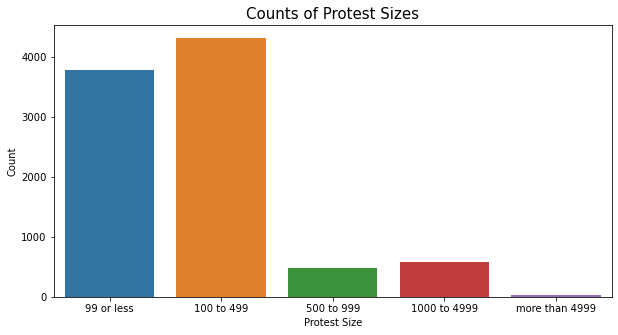

In [188]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
ax = sns.countplot(x="size", 
                   data=protest_df[protest_df["size"] != "unknown"],
                  order = ["99 or less", "100 to 499", "500 to 999", "1000 to 4999", "more than 4999"])
ax.set_title("Counts of Protest Sizes", fontsize = "15")
ax.set_xlabel("Protest Size")
ax.set_ylabel("Count")

In [189]:
protest_df["size"].value_counts()

unknown           7675
100 to 499        4321
99 or less        3789
1000 to 4999       574
500 to 999         489
more than 4999      25
Name: size, dtype: int64

Load in demographic data for comparison between places that had protests and places that did not. 

In [190]:
demo_df = pd.read_csv("../processed_data/demographic_data.csv")
demo_df.fips = [str(item).zfill(5) for item in demo_df.fips]
protest_fips = protest_df.fips.unique()

protest_fips_counts = protest_df.fips.value_counts().reset_index()
protest_fips_counts.columns = ["fips", "num"]
protest_fips_counts.sort_values(by = ["num"], inplace = True)

print(f"Of the total {len(demo_df)} FIPS code counties, {len(protest_fips)} had protests and {len(demo_df) - len(protest_fips)}.")

Of the total 1875 FIPS code counties, 1604 had protests and 271.


Text(0.5, 1.0, 'Distribution of Numbers of Protests')

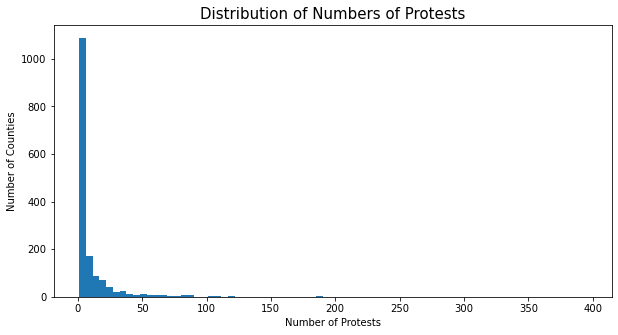

In [191]:
fig, ax = plt.subplots(1,1,figsize = (10,5))
ax.hist(protest_fips_counts["num"], 75)
ax.set_xlabel("Number of Protests")
ax.set_ylabel("Number of Counties")
ax.set_title("Distribution of Numbers of Protests", fontsize = "15")

In [192]:
print(protest_fips_counts)

       fips  num
1603  21071    1
1271  51117    1
1272  17193    1
1273  22075    1
1274  48213    1
...     ...  ...
4     53033  188
3     06073  230
2     41051  241
1     17031  248
0     06037  395

[1604 rows x 2 columns]


In [193]:
demo_df = demo_df.merge(protest_fips_counts, on = ["fips"], how = "left")
demo_df = demo_df.rename(columns = {"num":"num_protests"})
demo_df["num_protests"] = demo_df["num_protests"].fillna(0).astype(int)

In [204]:
values = [0, 1, 2]
conditions = [
    (demo_df["num_protests"]==0),
    (demo_df["num_protests"] > 0) & (demo_df["num_protests"] < 6),
    (demo_df["num_protests"] > 5)
]

demo_df["protests"] = np.select(conditions, values)

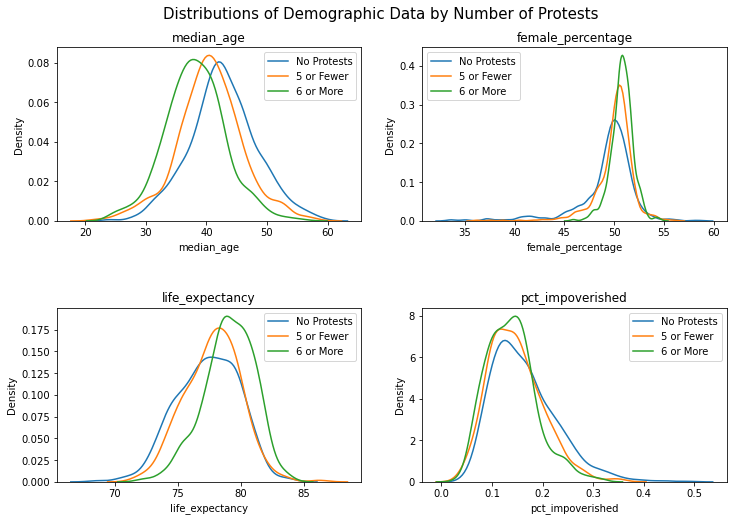

In [216]:
plot_var = ["median_age", "female_percentage", "life_expectancy","pct_impoverished"]

fig, axes = plt.subplots(2,2, figsize = (12,8))

for i, ax in enumerate(axes.ravel()):
    demo_var = plot_var[i]
    sns.kdeplot(data = demo_df[demo_df["protests"] == 0][demo_var], ax = ax, label = "No Protests")
    sns.kdeplot(data = demo_df[demo_df["protests"] == 1][demo_var], ax = ax, label = "5 or Fewer")
    sns.kdeplot(data = demo_df[demo_df["protests"] == 2][demo_var], ax = ax, label = "6 or More")
    ax.set_xlabel(demo_var)
    ax.set_ylabel("Density")
    ax.set_title(demo_var)
fig.suptitle("Distributions of Demographic Data by Number of Protests", y = 0.95, fontsize = "15")
fig.subplots_adjust(hspace = 0.5)
    
    